# Libraries

In [1]:
# IO
import os
import pathlib
from pathlib import Path
from glob import glob

# Utilities
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Import PyTorch
import torch
from torch import nn
## Ignite
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.handlers import ModelCheckpoint
from ignite.contrib.handlers import TensorboardLogger, global_step_from_engine
from ignite.handlers import EarlyStopping

# Import torch utilities
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.io import read_image

# Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

/home/iridescent/miniconda3/envs/ai/lib/python3.12/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


PyTorch version: 2.4.0
torchvision version: 0.19.0


# GPU availability

In [2]:
torch.cuda.is_available()

False

Line required for the code to be device-agnostic

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data preparation

## Import

I tried to make it os-agnostic, possibly messed something up

In [3]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
BROKENDATA_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_brokenData","")

## Read folder names and generate target classes

In [6]:
folder_list = glob(os.path.join(DATASET_FOLDER,"*",""), recursive = True)
subfolder_list = glob(os.path.join(DATASET_FOLDER,"*","*",""), recursive = True)

### Here, we choose whether we want a broader or more specific classifier
styles = [os.path.basename(os.path.normpath(x)) for x in subfolder_list]

In [7]:
styles

['Blobitecture',
 'Deconstructivism',
 'Eco-architecture',
 'Neo-futurism architecture',
 'Postmodern architecture',
 'Andean Baroque Architecture',
 'Baroque architecture',
 'Earthquake Baroque Architecture',
 'Rococo Architecture',
 'Russian Baroque Architecture',
 'Sicilian Baroque Architecture',
 'Achaemenid architecture',
 'Ancient Egyptian architecture',
 'Herodian architecture',
 'Roman Classical architecture',
 'Byzantine architecture',
 'Gothic architecture',
 'Medieval Architecture',
 'Norman Architecture',
 'Romanesque architecture',
 'Venetian Gothic Architecture',
 'American Foursquare architecture',
 'American craftsman style',
 'Art Nouveau architecture',
 'Art Deco architecture',
 'Bauhaus architecture',
 'Brutalism',
 'Chicago school architecture',
 'International style',
 'Beaux-Arts architecture',
 'Greek Revival architecture',
 'Palladian architecture',
 'Colonial architecture',
 'French Renaissance Architecture',
 'Georgian architecture',
 'Mannerist Architecture',

## Discard broken/not useful data

Set batch size and minimum pic dimension

In [8]:
BATCH_SIZE = 16
DIM = 256

Check for broken/small images and move them to a broken data folder

In [7]:
for i in range(len(subfolder_list)):
    for filename in os.listdir(subfolder_list[i]):
        image_path = str(subfolder_list[i]+filename)
        image = cv2.imread(image_path)
        height, width, channels = image.shape
        # If pic is broken
        if image is None:
            os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)
        # If pic is too small
        if min(height,width)<DIM:
            os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


## Data tensors

### Create data tensors

In [24]:
# Custom transform function to filter out None objects
class SkipNoneTransform:
    def __call__(self, data):
        # If the data is None, return None to skip it
        if data is None:
            return None
        return data  # Return the data as-is if it is not None

In [17]:
trans_comp = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    SkipNoneTransform(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale(1)
])

In [18]:
dataset = datasets.ImageFolder(DATASET_FOLDER, transform=trans_comp)

In [19]:
dataset

Dataset ImageFolder
    Number of datapoints: 11540
    Root location: /home/iridescent/Documents/IML/Project/Part2/_data/
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
               Grayscale(num_output_channels=1)
           )

In [20]:
train_set, test_set = torch.utils.data.random_split(dataset, [0.7, 0.3])
test_set, val_set = torch.utils.data.random_split(test_set, [0.7, 0.3])

In [35]:
train_set[567][0][0]

tensor([[-0.1711, -0.1267, -0.1137,  ..., -0.2479, -0.2479, -0.2479],
        [-0.1914, -0.1267, -0.1216,  ..., -0.2558, -0.2479, -0.2401],
        [-0.2071, -0.1424, -0.1405,  ..., -0.2636, -0.2558, -0.2479],
        ...,
        [-0.0478, -0.1799, -0.3646,  ..., -0.1956, -0.4287, -0.5535],
        [-0.1631, -0.2990, -0.4210,  ..., -0.1932, -0.4176, -0.5756],
        [-0.1834, -0.3765, -0.4630,  ..., -0.2583, -0.4592, -0.5936]])

In [22]:
styles = dataset.classes
styles

['21st_Century',
 'Baroque',
 'Classical',
 'Early_Christian_Medieval',
 'Eclecticism',
 'Modernism',
 'Neoclassicism',
 'Renaissance_and_Colonialism',
 'Revivalism']

In [10]:
X = []
targets = []

dim = (DIM,DIM)

for style in styles:
    #file_jpg = glob(DATASET_FOLDER+f'{style}/**/*.jpg', recursive=True) # uncomment this for broader classifier
    file_jpg = glob(DATASET_FOLDER+f'**/{style}/*.jpg', recursive=True) # uncomment this for more specific classifier

    for i, f in enumerate(file_jpg):
        img = cv2.imread(f)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA) # Best for shrinking
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #uncomment for bw image
        img = np.array(img)
        #img = img.transpose(2,0,1) # Channel first, only uncomment for color image
        img = img.astype('float32')
        img /= 255
        img = torch.from_numpy(img)
        X.append(img)
        targets.append(style)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG


Remember that in pytorch you need NCHW tensors

In [11]:
X = torch.stack(X, dim=0)
# X = X.unsqueeze(1) # uncomment for bw images
X.shape

torch.Size([11532, 256, 256])

Encode target variable to numeric

In [12]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(targets)
y = torch.as_tensor(y)
y

tensor([10, 10, 10,  ..., 43, 43, 43])

### Save and load tensors

Save and load tensors for future sessions

In [13]:
torch.save(X, os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorXbw.pt'))
torch.save(y, os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorTargetuber.pt'))

In [7]:
X =  torch.load(os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorX.pt'))
y = torch.load(os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorTarget.pt'))

/tmp/ipykernel_96894/4146380820.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X =  torch.load(os.path.join(str(CodeDirectory.parent.absolute()), '_tensorData','tensorX

### Set up training, validation and test set

Create sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8)

Check sizes

In [15]:
print("Length of X_train: ", len(X_train))
print("Length of y_train: ", len(y_train))
print("Length of X_val: ", len(X_val))
print("Length of y_val: ", len(y_val))
print("Length of X_test: ", len(X_test))
print("Length of y_test: ", len(y_test))

Length of X_train:  7380
Length of y_train:  7380
Length of X_val:  1845
Length of y_val:  1845
Length of X_test:  2307
Length of y_test:  2307


In [16]:
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

# Turn datasets into iterables (batches)
train_loader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_loader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

test_loader = DataLoader(val_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [14]:
print(f"Dataloaders: {train_loader, test_loader}")
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f8bdef7d580>, <torch.utils.data.dataloader.DataLoader object at 0x7f8bdf172ab0>)
Length of train dataloader: 462 batches of 16
Length of test dataloader: 116 batches of 16


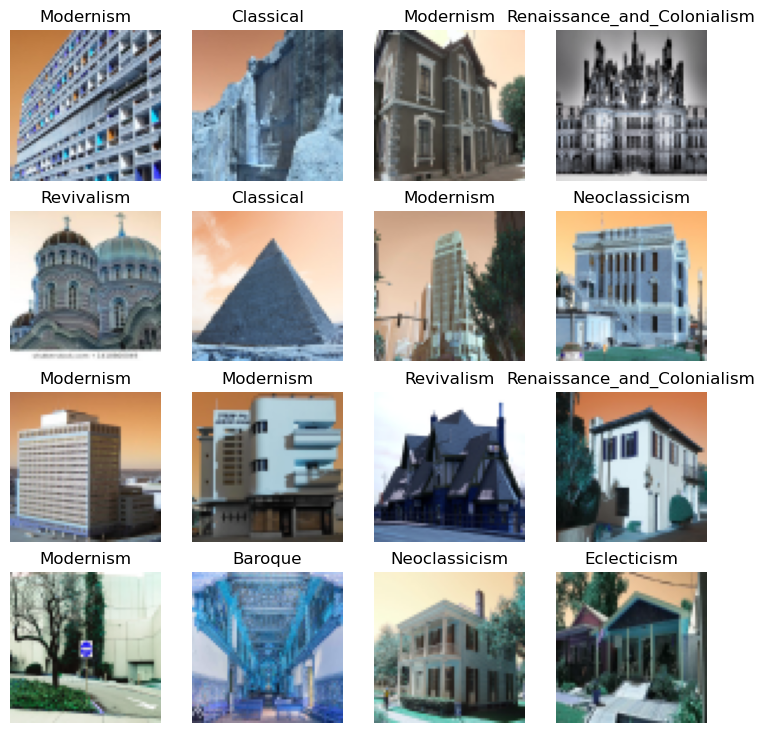

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    img = img.permute(1,2,0)
    plt.imshow(img)
    plt.title(le.inverse_transform([label])[0])
    plt.axis(False);

# Model building

## VGG16

In [22]:
class VGG16(nn.Module):
    def __init__(self, num_classes=len(styles)):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), #222
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #222
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)) #111
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #111
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #111
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) #55
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #55
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #55
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #55
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) #27
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), #27
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #27
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #27
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) #13
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) #6 
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6*6*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [23]:
num_classes = len(styles)
num_epochs = 20
learning_rate = 0.01

vgg16 = VGG16(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [24]:
summary(vgg16, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

### Build trainer

In [25]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

## ArtCoppo256

In [ ]:
class ArtCoppo(nn.Module):
    def __init__(self, n_channels: int, output_shape: int):
        super().__init__()
        # input dimension 256x256
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels,
                      out_channels=6,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=6,
                      out_channels=24,
                      kernel_size=13,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,
                         stride=4) # default stride value is same as kernel_size
            # 58x58 here
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=24,
                      out_channels=48,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=48,
                      out_channels=96,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                         stride=3) # default stride value is same as kernel_size
            # 18x18 here
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=96*18*18,
                      out_features=125),
            nn.Linear(in_features=125,
                      out_features=75),
            nn.Linear(in_features=75,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

ArtCop = ArtCoppo(n_channels=1,
    output_shape=len(styles))

## ArtCoppo - personal

In [16]:
class ArtCoppo(nn.Module):
    def __init__(self, n_channels: int, output_shape: int):
        super().__init__()
        # input dimension 64x64
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels,
                      out_channels=6,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=6,
                      out_channels=12,
                      kernel_size=6,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,
                         stride=1) # default stride value is same as kernel_size
            # 54x54 here
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=12,
                      out_channels=24,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=24,
                      out_channels=48,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=6,
                         stride=4) # default stride value is same as kernel_size
            # 12x12 here
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=48*12*12,
                      out_features=125),
            nn.Linear(in_features=125,
                      out_features=75),
            nn.Linear(in_features=75,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

ArtCop = ArtCoppo(n_channels=3,
    output_shape=len(styles))

In [18]:
summary(ArtCop, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 62, 62]             168
              ReLU-2            [-1, 6, 62, 62]               0
            Conv2d-3           [-1, 12, 57, 57]           2,604
              ReLU-4           [-1, 12, 57, 57]               0
         MaxPool2d-5           [-1, 12, 54, 54]               0
            Conv2d-6           [-1, 24, 52, 52]           2,616
              ReLU-7           [-1, 24, 52, 52]               0
            Conv2d-8           [-1, 48, 50, 50]          10,416
              ReLU-9           [-1, 48, 50, 50]               0
        MaxPool2d-10           [-1, 48, 12, 12]               0
          Flatten-11                 [-1, 6912]               0
           Linear-12                  [-1, 125]         864,125
           Linear-13                   [-1, 75]           9,450
           Linear-14                   

Send model to device

In [19]:
ArtCop.to(device)

ArtCoppo(
  (block_1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 12, kernel_size=(6, 6), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=6, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6912, out_features=125, bias=True)
    (2): Linear(in_features=125, out_features=75, bias=True)
    (3): Linear(in_features=75, out_features=9, bias=True)
  )
)

### Build trainer

#### Define loss function and optimizer

In [21]:
num_classes = len(styles)
num_epochs = 20
learning_rate = 0.01


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ArtCop.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

#### Create trainer

In [23]:
# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = ArtCop(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = ArtCop(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total)) 

Epoch [1/20], Step [462/462], Loss: 2.2739
Accuracy of the network on the 5000 validation images: 16.585365853658537 %
Epoch [2/20], Step [462/462], Loss: 1.8185
Accuracy of the network on the 5000 validation images: 20.16260162601626 %
Epoch [3/20], Step [462/462], Loss: 1.5312
Accuracy of the network on the 5000 validation images: 18.26558265582656 %
Epoch [4/20], Step [462/462], Loss: 2.2644
Accuracy of the network on the 5000 validation images: 23.956639566395665 %
Epoch [5/20], Step [462/462], Loss: 1.7681
Accuracy of the network on the 5000 validation images: 23.848238482384822 %
Epoch [6/20], Step [462/462], Loss: 1.8500
Accuracy of the network on the 5000 validation images: 21.02981029810298 %
Epoch [7/20], Step [462/462], Loss: 1.8659
Accuracy of the network on the 5000 validation images: 24.769647696476966 %
Epoch [8/20], Step [462/462], Loss: 2.0023
Accuracy of the network on the 5000 validation images: 24.932249322493224 %
Epoch [9/20], Step [462/462], Loss: 2.1099
Accuracy